# <center>Фаза1. Неделя1. Среда</center>
# <center>A/B тесты</center>

## __Сегодня__

1. Что же такое A/B тесты
2. Важные моменты при проведении A/B тестов
3. Достоинства и недостатки A/B тестов

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm as tqdm_notebook 

### 1. Что же такое A/B тесты

> Допустим, мы работаем в интернет-издании. Каждый день к нам заходят пользователи и смотрят наш контент. Наша задача рекомендовать пользователю максимально релевантные статьи, чтобы пользователь больше времени проводил на нашем сайте, возращался в дальнейшем.

* Ранее у нас уже была какая-то модель рекомендации, но у нас появилась новая идея, как сделать рекомендации лучше.

* Если мы ее внедрим, как количественно оценить, что рекомендации стали лучше?

* Именно этим и занимается **A/B - тестирование**.

#### Обобщенный алгоритм A/B теста

Коротко идею A/B - тестировия можно описать следующим образом:

* Наш трафик делится на две групппы(может и больше), называемый _контрольной_ и _экспериментальной_
* _Контрольная_ группа группа получает старые рекомендации
* _Экспериментальная_ группа получает новые рекомендации
* После проведения A/B - теста зафиксировать измеряемую нами метрику в контрольной и экспериментальной группах и сделать вывод, есть ли **статистически значимые(!)** отличия.

![center h:150](https://i2.wp.com/mlinproduction.com/wp-content/uploads/2020/05/ui-ab-test.png?w=826&ssl=1)

#### Для чего нужны A/B - тесты

* Создание любого продукта — непрерывный процесс поиска улучшений, которые нужно фиксировать.

* Каждая гипотеза или идея нововведения требует проверки — иначе наш продукт может уйти не туда.

* Ожидаемое улучшение не всегда на самом деле улучшает продукт — новый функционал может быть никому не нужен или реализация портит всю затею.


## 2. Важные моменты при проведении A/B тестов

#### Требования

* Основные требования к корректному проведению **A/B - теста**:

    1. Наблюдения (пользователи) независимы
    2. группы пользователей эквивалентны (из одной ГС)  
    
Последнее может нарушаться по разным причинам, например:  
    - данные приходят в систему аналитики некорректно.  
    - инструмент «деления» нашего трафика работает ошибочно


#### A/A - тест

Чтобы удостовериться, что группы пользователей действительно эквивалентны(из одной ГС), и нет никаких "человеческих ошибок" при подготовке данных необходимо провести так называемый **А/А - тест**:

* Принцип работы точно такой же, как и при А/B - тесте, только и контрольная и экспериментальная группы видят одно и то же.

* Если ключевые для нас метрики не имеют статистически значимых различий, считаем, что группы пользователей эквивалентны



#### Стабильность кумулятивных метрик

In [148]:
days = np.arange(1, 31, 1)

total_control = np.array([])
total_experiment = np.array([])

daily_mean1 = []
daily_mean2 = []

cummulative_daily_mean1 = []
cummulative_daily_mean2 = []


for day in days:
    control = np.random.normal(100, 40, size= 10)
    experiment = np.random.normal(105, 40, size= 10)
    
    total_control = np.append(total_control, control)
    total_experiment = np.append(total_experiment, experiment)
    
    cummulative_daily_mean1.append(total_control.mean())
    cummulative_daily_mean2.append(total_experiment.mean())
    
    daily_mean1.append(control.mean())
    daily_mean2.append(experiment.mean())

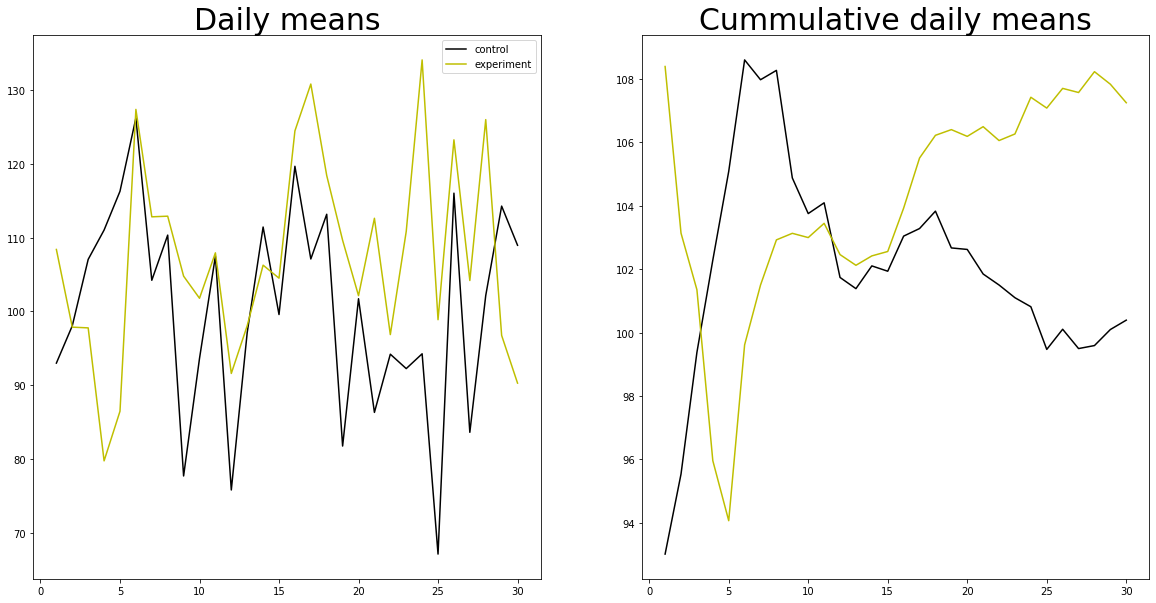

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

axes[1].set_title('Cummulative daily means', size=30)
axes[0].set_title('Daily means', size=30)

axes[0].plot(days, daily_mean1, color='k', label='control')
axes[0].plot(days, daily_mean2, color='y', label='experiment')

axes[1].plot(days, cummulative_daily_mean1, color='k', label='control')
axes[1].plot(days, cummulative_daily_mean2, color='y', label='experiment')

axes[0].legend();


Как мы видим, ежедневные данные прыгают и явным образом не видно, что метрика в экспериментальной группе лучше метрики в контрольной

Чтобы нагляднее увидеть разницу между группами, строят график относительного различия, часто строят график относительного различия 
  
$diff = \dfrac{cummulativeA}{cummulativeB} - 1$

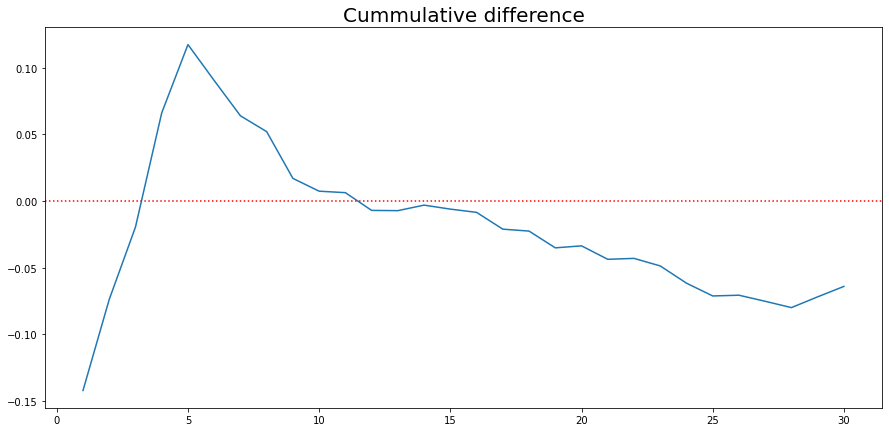

In [165]:
diff = (np.array(cummulative_daily_mean1)/np.array(cummulative_daily_mean2)) - 1


plt.figure(figsize=(15,7))

plt.plot(days, diff)
plt.axhline(0, linestyle=':', color='r')
plt.title('Cummulative difference', size=20)
plt.show()

#### Анализ выбросов и всплесков

Зачастую, в реальных задачах, есть выбросы, аномально большие/маленькие значения: 
1. Они безусловно возможны, но редки.  
2. Они могут сильно повлиять и исказить поиск нашего ответа на вопрос есть ли различия в среднем чеке, например
3. Их лучше убирать
4. Как правило исследователь сам решает, что считать выбросом(99%, 95%) 

#### Peeking Problem(Проблема подглядывания)

Мы решили подводить итоги на уровне значимости 5% каждый день (или просто больше одного раза за время теста).  

In [138]:
days = np.arange(1, 61, 1)

total_control = np.array([])
total_experiment = np.array([])

daily_mean1 = []
daily_mean2 = []
p_values = []
for day in days:
    control = np.random.normal(100, 60, size= 10)
    experiment = np.random.normal(100, 60, size= 10)
    
    total_control = np.append(total_control, control)
    total_experiment = np.append(total_experiment, experiment)
    
    cummulative_daily_mean1.append(total_control.mean())
    cummulative_daily_mean2.append(total_experiment.mean())
    
    _, p_value = ttest_ind(total_control, total_experiment)
    p_values.append(p_value)

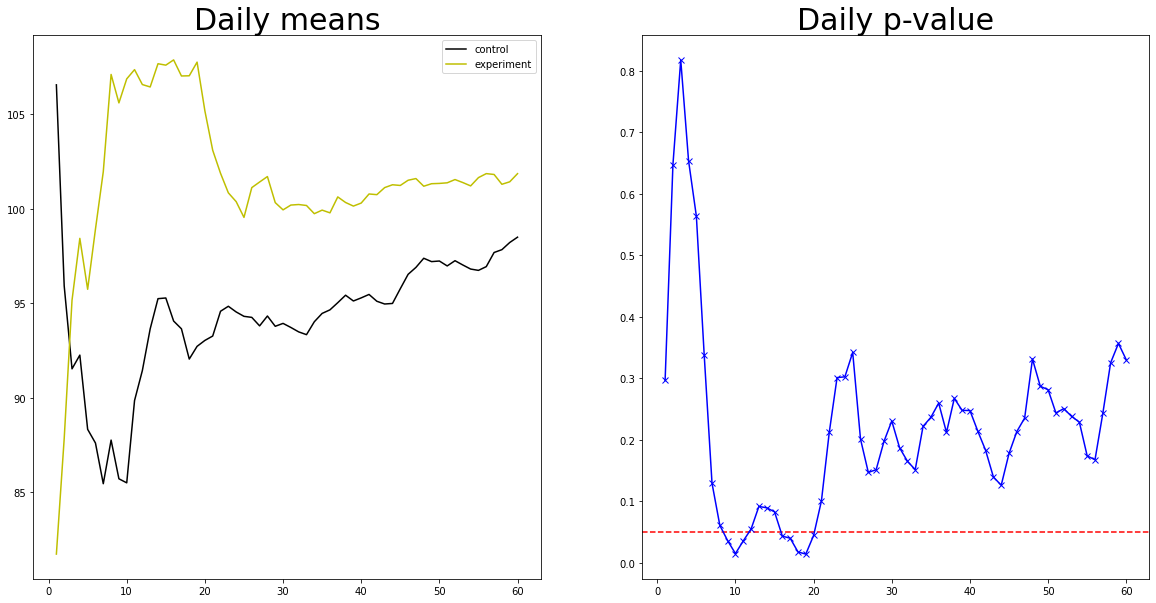

In [139]:
fig, axes =plt.subplots(1, 2, figsize=(20,10))

axes[1].set_title('Daily p-value', size=30)
axes[0].set_title('Daily means', size=30)

axes[0].plot(days, daily_mean1, color='k', label='control')
axes[0].plot(days, daily_mean2, color='y', label='experiment')

axes[1].axhline(0.05, ls='--', color='red')
axes[1].plot(days, p_values, color='b', marker='x')

axes[0].legend();


Глядя на картинку выше, в очередной раз подчеркивается важность вычисления размера выборки!!!

### Расчет необходимого количества элементов выборки

Есть много калькуляторов. 

* https://abtestguide.com/calc/
* https://mindbox.ru/tools/ab-test-calculator/
* https://yandex.ru/adv/statvalue

Продвинутая формула:
    
$n > \dfrac{\left[ \left( z_{(1-\frac{\alpha}{2})} + z_{(1-\beta)} \right) \right]^2 \cdot \left(\sigma_{A}^2 + \sigma_{B}^2 \right)}{\bigtriangleup^2}$

$z_{(1-\frac{\alpha}{2})}$ - квантиль уровня $1-\frac{\alpha}{2}$  
$z_{(1-\beta)}$ - квантиль уровня ${(1-\beta)}$  
$\sigma_{A}^2$ - дисперсия группы $A$  
$\sigma_{B}^2$ - дисперсия группы $B$  
$\bigtriangleup$ - Minimal Detect Effect(Минимальный детектируемый эффект)